# Machine Learning with Python

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 3.3 Exploring models

This is a case study in investigating the behaviour of a linear model.

We will use data from the “Current Population Survey” from 1985 to predict wage as a function of various features such as experience, age, or education.

In [ ]:
from sklearn.datasets import fetch_openml
survey = fetch_openml(data_id=534, as_frame=True, parser='auto')

In [ ]:
X = survey.data[survey.feature_names]
X.head()

In [ ]:
survey.target

Make a train/test split.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(survey.data, 
                                                    survey.target, 
                                                    random_state=0)


In [ ]:
X_train.head()

Use a scatter matrix to explore the relationships between the numerical variables.

In [ ]:
pd.plotting.scatter_matrix(X_train, c=y_train, figsize=(15, 15),
                           marker='o', hist_kwds={'bins': 20}, s=60,
                           alpha=.8)

plt.show()

In [ ]:
X2 = X_train.copy()
X2['WAGE'] = y_train

In [74]:
X2.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR,WAGE
101,10,no,male,12,not_member,28,White,Other,Construction,Married,1.000000
97,12,no,male,33,member,51,White,Other,Construction,Married,1.176091
202,17,yes,male,14,not_member,37,White,Management,Other,Unmarried,1.259116
54,13,no,male,0,not_member,19,White,Other,Other,Unmarried,0.602060
30,14,no,male,13,not_member,33,White,Other,Other,Unmarried,0.949390


In [ ]:
pd.plotting.scatter_matrix(X2, c=y_train, figsize=(15, 15),
                           marker='o', hist_kwds={'bins': 20}, s=60,
                           alpha=.8)

plt.show()

Build a pipeline to preprocess the data.

In [ ]:
X_train.dtypes

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns = ["EDUCATION", "EXPERIENCE", "AGE"]

ct = ColumnTransformer([('encode', OneHotEncoder(drop="if_binary"), categorical_columns)],
                       remainder='passthrough',
                       verbose_feature_names_out=False) 

pipe = Pipeline([  ('process', ct)  ])

In [ ]:
pipe.fit(X_train)

In [ ]:
pipe.get_feature_names_out()

In [ ]:
X_train_ = pipe.transform(X_train)
X_train_[:5]

We are going to try to apply a linear model to predice wages. 
Would it be helpful to transform the target value first?

In [ ]:
y_train_ = np.log10(y_train)

In [ ]:
X2 = X_train.copy()
X2['WAGE'] = y_train_

In [ ]:
pd.plotting.scatter_matrix(X2, c=y_train, figsize=(15, 15),
                           marker='o', hist_kwds={'bins': 20}, s=60,
                           alpha=.8)

plt.show()

In [81]:
y_test_ = np.log10(y_test)

Try a `Ridge` regression model to predict wages.

In [83]:
from sklearn.linear_model import Ridge

pipe2 = Pipeline([  ('process', ct),
                    ('predict', Ridge(alpha=0.01)) ])


In [85]:
pipe2.fit(X_train,y_train_)

Pipeline(steps=[('process',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose_feature_names_out=False)),
                ('predict', Ridge(alpha=0.01))])

In [87]:
y_pred_ = pipe2.predict(X_test)
from sklearn.metrics import r2_score
print("Coefficient of determination, r2 = %.3f" % r2_score(y_test_, y_pred_))



Coefficient of determination, r2 = 0.314


Examine the coefficients of the trained model. How does scaling affect these?

array(['RACE_Hispanic', 'RACE_Other', 'RACE_White', 'OCCUPATION_Clerical',
       'OCCUPATION_Management', 'OCCUPATION_Other',
       'OCCUPATION_Professional', 'OCCUPATION_Sales',
       'OCCUPATION_Service', 'SECTOR_Construction',
       'SECTOR_Manufacturing', 'SECTOR_Other', 'MARR_Unmarried',
       'UNION_not_member', 'SEX_male', 'SOUTH_yes', 'EDUCATION',
       'EXPERIENCE', 'AGE'], dtype=object)

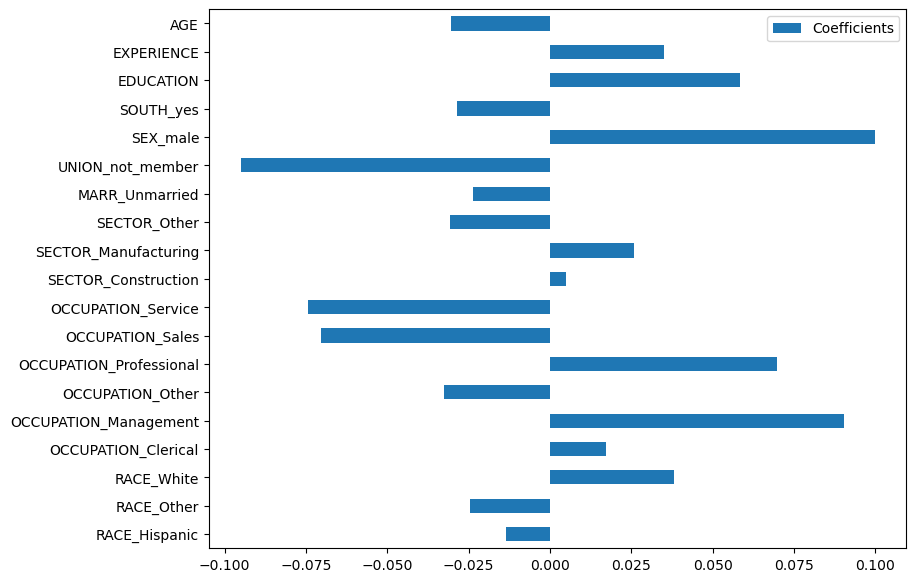

In [93]:
feature_names = pipe2[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    pipe2[-1].coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs.plot.barh(figsize=(9, 7))
plt.show()

<Axes: >

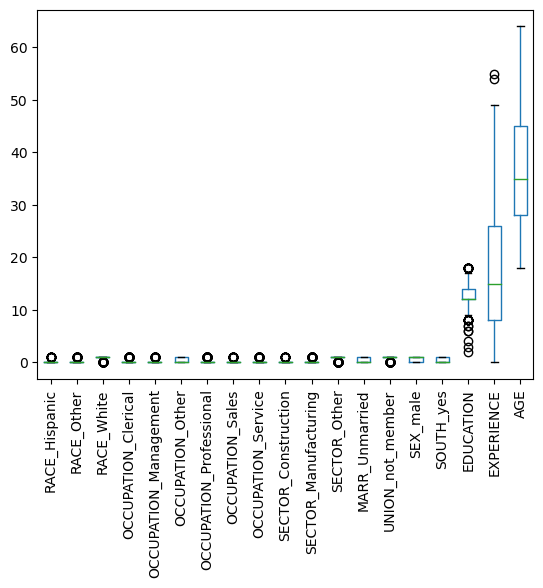

In [133]:
df = pd.DataFrame(data=X_train_,columns=feature_names)
df.boxplot(rot=90, grid=False)

In [94]:
from sklearn.preprocessing import StandardScaler

pipe3 = Pipeline([  
    ('process', ct),
    ('scaling', StandardScaler()),
    ('predict', Ridge(alpha=0.01)) ])

In [96]:
pipe3.fit(X_train,y_train_)

Pipeline(steps=[('process',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose_feature_names_out=False)),
                ('scaling', StandardScaler()), ('predict', Ridge(alpha=0.01))])

In [98]:
y_pred_ = pipe3.predict(X_test)
print("Coefficient of determination, r2 = %.3f" % r2_score(y_test_, y_pred_))


Coefficient of determination, r2 = 0.314


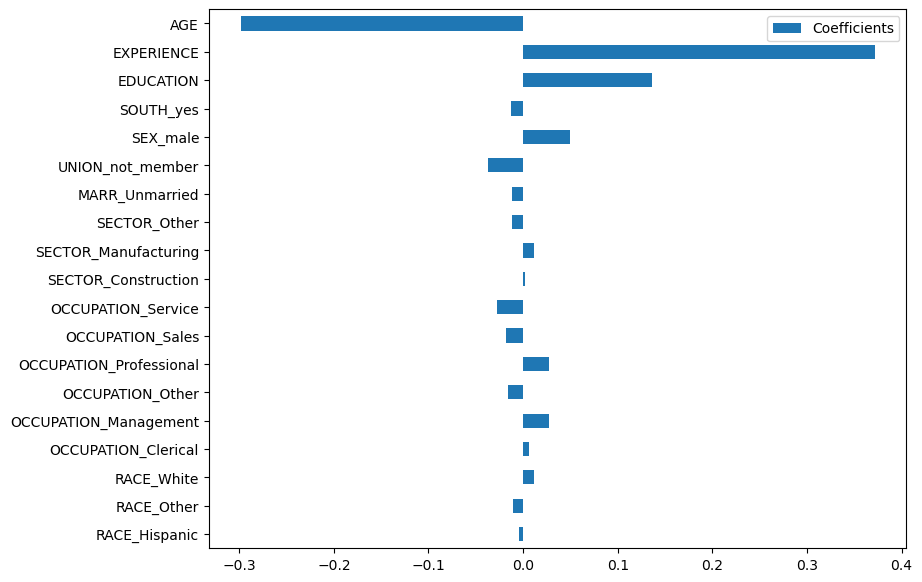

In [100]:
feature_names = pipe3[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    pipe3[-1].coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs.plot.barh(figsize=(9, 7))
plt.show()

How stable are the coefficients in a 5-fold cross-validation?

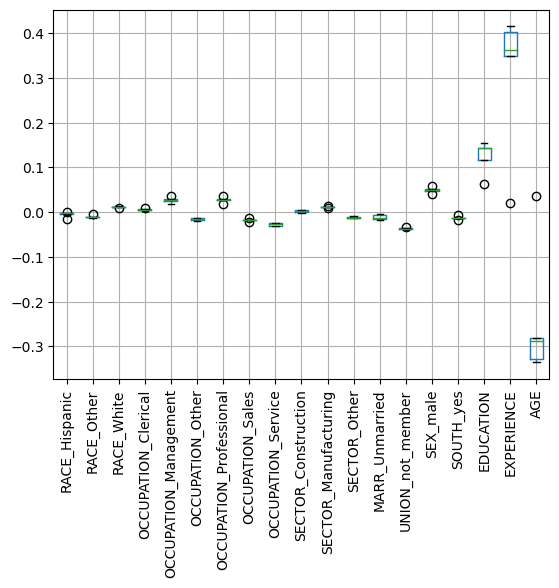

In [145]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True,random_state=2)

coefs = []
for train, test in kf.split(X_train):
    pipe3.fit(X_train.iloc[train], y_train_.iloc[train])
    coefs.append( pipe3[-1].coef_ )

coefs = np.array(coefs)
feature_names = pipe3[:-1].get_feature_names_out()

df = pd.DataFrame(data=coefs,columns=feature_names)
df.boxplot(rot=90)
plt.show()


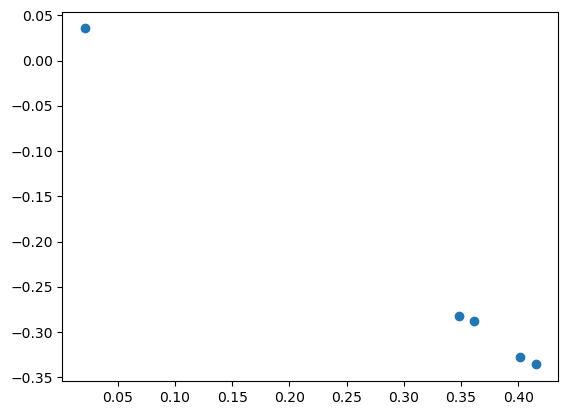

In [152]:
plt.scatter(x='EXPERIENCE',y='AGE',data=df)
plt.show()

In [138]:
X_train_noAGE = X_train.drop('AGE',axis=1)
X_test_noAGE = X_test.drop('AGE',axis=1)

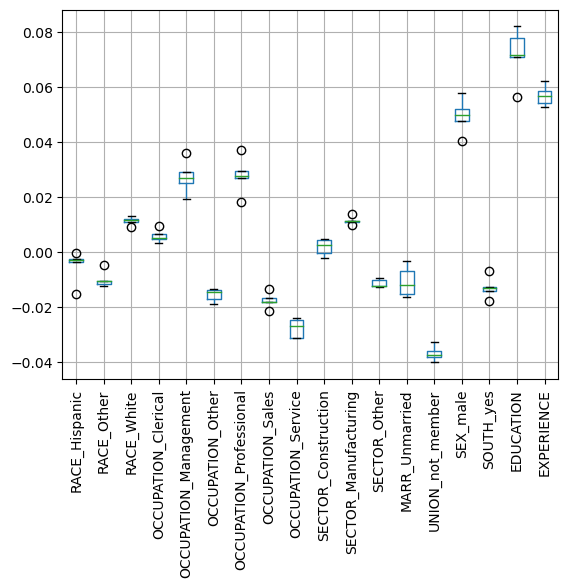

In [141]:

coefs = []
for train, test in kf.split(X_train_noAGE):
    pipe3.fit(X_train_noAGE.iloc[train], y_train_.iloc[train])
    coefs.append( pipe3[-1].coef_ )

feature_names = pipe3[:-1].get_feature_names_out()
coefs = np.array(coefs)
df = pd.DataFrame(data=coefs,columns=feature_names)
df.boxplot(rot=90)
plt.show()

Try to optimise the `alpha` hyperparameter.

In [172]:
from sklearn.model_selection import GridSearchCV

parameters = {'predict__alpha':[0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 50, 100]}

gs = GridSearchCV(pipe3, 
                  parameters, 
                  cv=5,
                  scoring='r2'
                  )
gs.fit(X_train_noAGE,y_train_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('process',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encode',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['RACE',
                                                                          'OCCUPATION',
                                                                          'SECTOR',
                                                                          'MARR',
                                                                          'UNION',
                                                                          'SEX',
                                                                          'SOUTH'])],
                                                          verbose_feature_names_out=False)),
                                       ('scaling', StandardScaler()),
                                       ('predict', Ridge(alpha=50))]),
             param_grid={'predict__alpha': [0.001, 0.01, 0.1, 1, 2, 5, 10, 20,
                                            50, 100]},
             scoring='r2')

In [173]:
gs.best_params_

{'predict__alpha': 50}

In [174]:
gs.best_score_

0.30671268494119985

In [175]:
pipe3.set_params(**gs.best_params_)

Pipeline(steps=[('process',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose_feature_names_out=False)),
                ('scaling', StandardScaler()), ('predict', Ridge(alpha=50))])

In [176]:
pipe3.fit(X_train_noAGE, y_train_)
y_pred_ = pipe3.predict(X_test_noAGE)
print("Coefficient of determination, r2 = %.3f" % r2_score(y_test_, y_pred_))

Coefficient of determination, r2 = 0.316


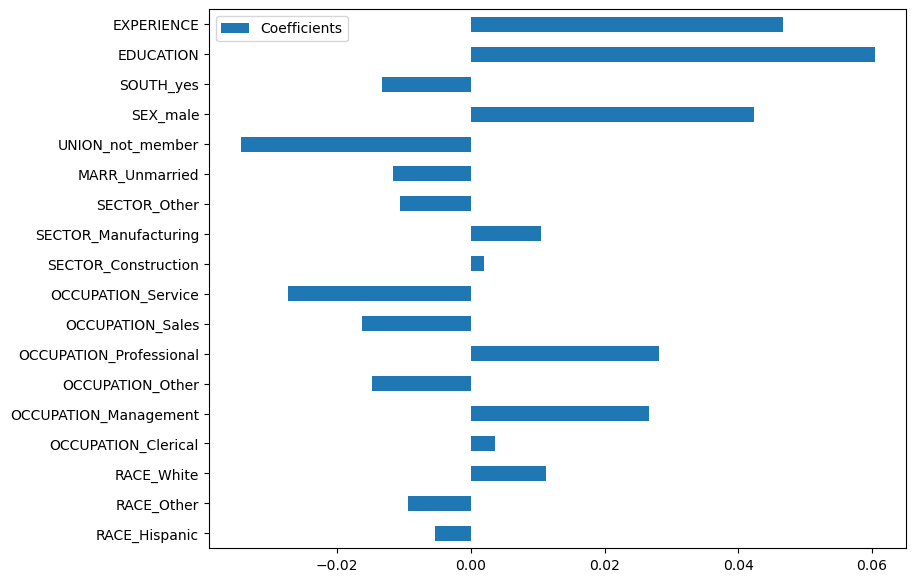

In [177]:
feature_names = pipe3[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    pipe3[-1].coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs.plot.barh(figsize=(9, 7))
plt.show()